## Abstract

Project will use 3 different statistical models (linear regression, decision trees, and random forests) to predict the amount of bike rentals taken out for certain days, given weather, season, and time of day information. Goal is to compare model performance and verify well known facts about these models and their methods - eg. linear regression underfits, decision trees overfit, feature-target correlation is important, etc. 

## TODO:

Questions to answer in this analysis. 
<ul>
    <li>verify that prediction accuracy is: random forests > decision trees > linear regression</li>
    <li>verify linear regression underfits, decision trees overfit, random forests in between</li>
    <li>test correlation between feature-target correlation and accuracy</li>
    <li>test effectiveness of breaking up categorical features into dummy variables</li>
    <li>test decision trees'/random forests' hyperparameter modification effects</li>
</ul>

In [1]:
import psycopg2 as psql
import sqlalchemy as alc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from decouple import AutoConfig
from pathlib import Path
from importlib import reload

import utils

In [2]:
config = AutoConfig(Path('./.env'))

In [3]:
# Working on integrating Pg with Python for a more streamlined process
engine = alc.create_engine(
    f"postgresql+psycopg2://{config('DB_USER')}:{config('DB_PASS')}@{config('DB_HOST')}/{config('DB_NAME')}", 
)

In [4]:
data = pd.read_sql_table('hour', engine)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  object        
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  bool          
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  bool          
 9   weathersit  17379 non-null  object        
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64         
 16  cnt         17379 non-

## Surface Analysis

From the <a href="https://public.tableau.com/app/profile/rinat.ibragimov/viz/UCIBikeRentals/RentalsoverTimewAmb_Temp_">Tableau</a> plots, looks like there exists some correlation between hour of the day and the amount of rentals. And according to rentals vs hr graph, there is correlation in behavior in users by *time of day*, meaning its best to group hours to remove noise: <em>morning (1), afternoon (2), evening (3), night (4)</em>.

In [5]:
st = "SELECT *, "\
            "CASE WHEN hr < 6 THEN 4 " \
                 "WHEN hr < 12 THEN 1 " \
                 "WHEN hr < 18 THEN 2 " \
                 "ELSE 3 END day_period " \
            "FROM hour;"

In [6]:
time_pd = pd.read_sql(st, engine)
time_pd.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day_period
0,1,2011-01-01,1,0,1,0,False,6,False,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,False,6,False,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,False,6,False,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,False,6,False,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,False,6,False,1,0.24,0.2879,0.75,0.0,0,1,1,4


Removing the following features:
<ul>
    <li>features directly related to <em>cnt</em>: <em><b>casual, registered</b></em></li>
    <li><em><b>yr</b></em> as there are only 2 years and they hold no meaning for prediction of any future data.</li>
    <li><em><b>dteday, mnth, hr</b></em> as those are directly related to <em>season</em> and <em>day_period</em></li>
    <li><em><b>atemp</b></em> as it is directly related to <em>temp</em>, but from the correlation matrix, temperature is slightly more correlated with <em>cnt</em></li>
</ul>

In [7]:
# Ignore features correlated with the 'cnt' column being predicted
not_interest = {'yr', 'casual', 'registered', 'dteday', 'mnth', 'hr', 'atemp'}
features = set(time_pd.columns).difference(not_interest)
features = sorted(features)
features

['cnt',
 'day_period',
 'holiday',
 'hum',
 'instant',
 'season',
 'temp',
 'weathersit',
 'weekday',
 'windspeed',
 'workingday']

### Correlation Map

In [8]:
corr = time_pd[features].drop(columns=['instant']).corr()
corr

,cnt,day_period,holiday,hum,season,temp,weathersit,weekday,windspeed,workingday
cnt,1.000000,-0.378318,-0.030927,-0.322911,0.178056,0.404772,-0.142426,0.026900,0.093234,0.030284
day_period,-0.378318,1.000000,-0.000702,0.144593,0.006617,-0.061551,-0.035784,0.002173,-0.109462,-0.000897
holiday,-0.030927,-0.000702,1.000000,-0.010588,-0.009585,-0.027340,-0.017036,-0.102088,0.003988,-0.252471
hum,-0.322911,0.144593,-0.010588,1.000000,0.150625,-0.069881,0.418130,-0.037158,-0.290105,0.015688
season,0.178056,0.006617,-0.009585,0.150625,1.000000,0.312025,-0.014524,-0.002335,-0.149773,0.013743
temp,0.404772,-0.061551,-0.027340,-0.069881,0.312025,1.000000,-0.102640,-0.001795,-0.023125,0.055390
weathersit,-0.142426,-0.035784,-0.017036,0.418130,-0.014524,-0.102640,1.000000,0.003311,0.026226,0.044672
weekday,0.026900,0.002173,-0.102088,-0.037158,-0.002335,-0.001795,0.003311,1.000000,0.011502,0.035955
windspeed,0.093234,-0.109462,0.003988,-0.290105,-0.149773,-0.023125,0.026226,0.011502,1.000000,-0.011830
workingday,0.030284,-0.000897,-0.252471,0.015688,0.013743,0.055390,0.044672,0.035955,-0.011830,1.000000


<AxesSubplot: >

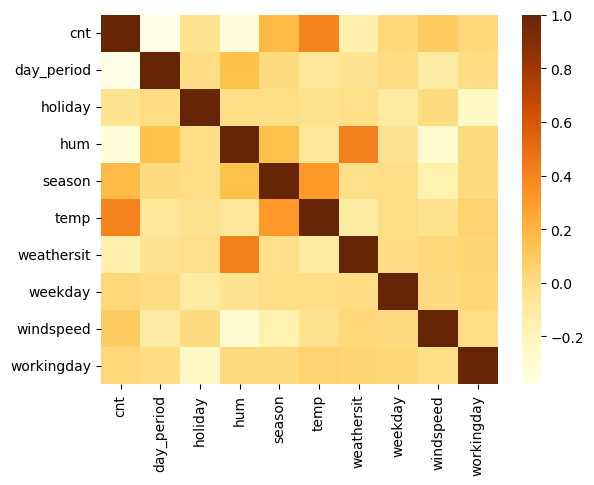

In [9]:
sns.heatmap(corr, cmap=sns.color_palette("YlOrBr", as_cmap=True))

In [10]:
# Absolute correlation values as don't want to ignore negative correlation
cnt_corr = corr.loc['cnt', :].abs().sort_values(ascending=False)
cnt_corr

cnt           1.000000
temp          0.404772
day_period    0.378318
hum           0.322911
season        0.178056
weathersit    0.142426
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

### Categorical Features -> Dummy Vars
Correlation values are ambiguous given that some features are categorical. Breaking up into dummy variables.

In [11]:
cat_features = ['season', 'weathersit', 'weekday', 'day_period']

In [12]:
dummy = pd.get_dummies(time_pd[features], columns=cat_features)
dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17379 non-null  int64  
 1   holiday       17379 non-null  bool   
 2   hum           17379 non-null  float64
 3   instant       17379 non-null  int64  
 4   temp          17379 non-null  float64
 5   windspeed     17379 non-null  float64
 6   workingday    17379 non-null  bool   
 7   season_1      17379 non-null  bool   
 8   season_2      17379 non-null  bool   
 9   season_3      17379 non-null  bool   
 10  season_4      17379 non-null  bool   
 11  weathersit_1  17379 non-null  bool   
 12  weathersit_2  17379 non-null  bool   
 13  weathersit_3  17379 non-null  bool   
 14  weathersit_4  17379 non-null  bool   
 15  weekday_0     17379 non-null  bool   
 16  weekday_1     17379 non-null  bool   
 17  weekday_2     17379 non-null  bool   
 18  weekday_3     17379 non-nu

In [13]:
dummy.head()

,cnt,holiday,hum,instant,temp,windspeed,workingday,season_1,season_2,season_3,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,day_period_1,day_period_2,day_period_3,day_period_4
0,16,False,0.81,1,0.24,0.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
1,40,False,0.80,2,0.22,0.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
2,32,False,0.80,3,0.22,0.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
3,13,False,0.75,4,0.24,0.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
4,1,False,0.75,5,0.24,0.0,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True


## Methods

<ul>
    <li>Will use k-fold cross validation to train/test the models. Will use $k=10$ for no other reason than it's the most common choice of k. Reason for k-fold CV is because I want to minimize variance in the model predictions.</li>
    <li>Want to test the accuracy gain/loss from adding more and more less correlated features.</li>
    <li>Will be using RMSE since the rentals seem to follow a general year-to-year pattern (at least as observed in years 2011, 2012) and any deviation from that is very unlikely and undesirable.</li>
</ul>

## Linear Regression

Will first test the predictions of a basic linear regression model.

In [14]:
reload(utils)

<module 'utils' from '/home/rimov/Documents/Code/Studies/bike-sharing/utils.py'>

In [15]:
corr_features = corr.loc[:, 'cnt'].sort_values(ascending=False).drop('cnt')
corr_features

temp          0.404772
season        0.178056
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
day_period   -0.378318
Name: cnt, dtype: float64

In [16]:
dummy.columns

Index(['cnt', 'holiday', 'hum', 'instant', 'temp', 'windspeed', 'workingday',
       'season_1', 'season_2', 'season_3', 'season_4', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'day_period_1', 'day_period_2', 'day_period_3',
       'day_period_4'],
      dtype='object')

In [17]:
corr_features.keys()

Index(['temp', 'season', 'windspeed', 'workingday', 'weekday', 'holiday',
       'weathersit', 'hum', 'day_period'],
      dtype='object')

In [18]:
permuts = 30
errors = []

for i in range(permuts):
    rng = np.random.default_rng(i)
    fs = rng.permutation(corr_features.keys())

    preds, times = utils.kfold_cv_progressive(dummy, 'instant', 'lin_reg', fs, 'cnt', 10)
    error = utils.get_predict_metrics(preds, 'cnt', times)
    errors.append(error)

AttributeError: module 'utils' has no attribute 'get_error_metrics'

In [ ]:
import regex as re

In [ ]:
for errs in errors:
    print(errs.keys())
    for k, err in errs.items():
        if k.startswith('9_'):
            print(err, '\n')

In [ ]:
data_pred = data.merge(lin_preds, how='left', on='instant').sort_values('cnt')
data_pred.head()

In [ ]:
pred_cols = data_pred.filter(regex=r'^\d+-\w+').columns.to_numpy()
pred_cols

In [ ]:
corr_features

In [ ]:
lin_rmses = {col: mean_squared_error(data_pred.loc[:, 'cnt'], data_pred.loc[:, col], squared=False) for col in pred_cols}
lin_rmses

In [ ]:
lin_rmses = mean_squared_error(data_pred.loc[:, 'cnt'], data_pred.loc[:, 'lin_predict'], squared=False)
lin_rmses

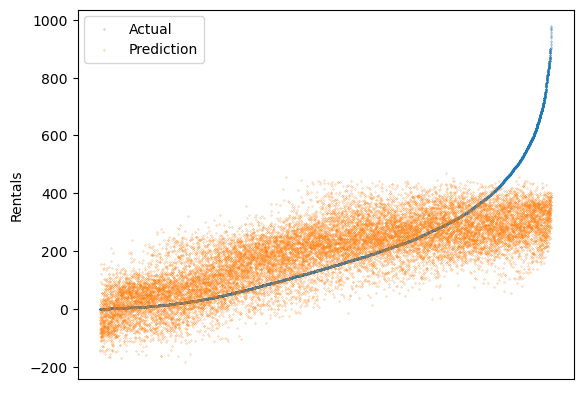

In [100]:
plt.scatter(range(data_pred.shape[0]), data_pred['cnt'], s=0.04, label='Actual')
plt.scatter(range(data_pred.shape[0]), data_pred['lin_predict'], s=0.04, label='Prediction')
plt.ylabel('Rentals')
plt.xticks([])
plt.legend()
plt.show()

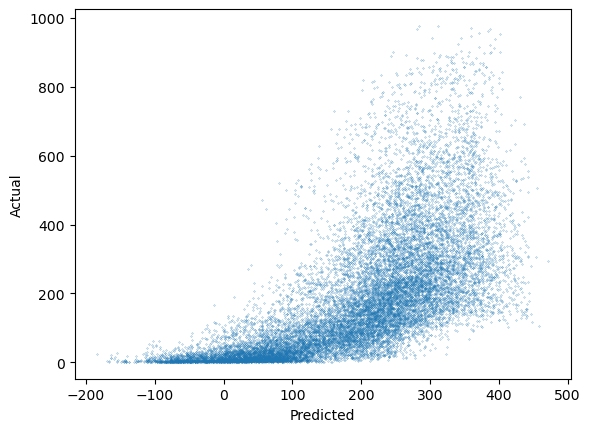

In [101]:
plt.scatter(data_pred['lin_predict'], data_pred['cnt'], s=0.04)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### NOTE:

As assumed, the linear regression model underfits the data, and perhaps isn't the best predictive model to begin with due to the exponential distribution of the rental data.

## Decision Trees:

In [24]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [25]:
k = 10
folds = [set(f) for f in np.array_split(rand, k)]
preds = dict()

In [26]:
for i, test_idx in enumerate(folds):
    # Get the k-1 training folds
    train_idx = list(set(dummy.index).difference(test_idx))
    train = dummy.iloc[train_idx, :]
    test_idx = list(test_idx)
    test = dummy.iloc[test_idx, :]
    
    mod = DecisionTreeRegressor(random_state=i, max_depth=6)
    mod.fit(train[features], 
            train['cnt'])
    
    pred = dict(zip(test_idx, mod.predict(test[features])))
    preds.update(pred)
    
preds = pd.Series(preds).rename('tree_predict')

In [27]:
tree_pred = pd.concat([data_pred, preds], axis=1)
tree_pred.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,lin_predict,tree_predict
10896,10897,2012-04-04,2,1,4,4,False,3,True,1,0.42,0.4242,0.67,0.0896,0,1,1,33.75000,9.583012
8052,8053,2011-12-07,4,0,12,4,False,3,True,3,0.46,0.4545,1.00,0.1642,0,1,1,-10.50000,11.855263
10201,10202,2012-03-06,1,1,3,3,False,2,True,1,0.18,0.1667,0.51,0.2836,0,1,1,-57.53125,4.955056
210,211,2011-01-10,1,0,1,1,False,1,True,1,0.12,0.1212,0.50,0.2836,1,0,1,-68.50000,4.378378
212,213,2011-01-10,1,0,1,3,False,1,True,1,0.12,0.1212,0.50,0.2239,0,1,1,-75.50000,6.353896


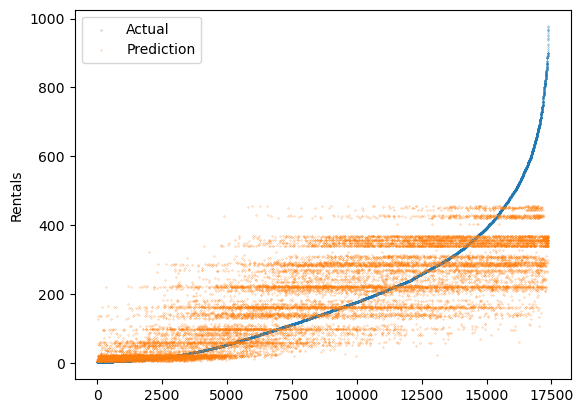

In [28]:
plt.scatter(range(tree_pred.shape[0]), tree_pred['cnt'], s=0.04, label='Actual')
plt.scatter(range(tree_pred.shape[0]), tree_pred['tree_predict'], s=0.04, label='Prediction')
plt.ylabel('Rentals')
plt.legend()
plt.show()

In [29]:
tree_rmses = mean_squared_error(tree_pred.loc[:, 'cnt'], tree_pred.loc[:, 'tree_predict'], squared=False)
tree_rmses

128.89031266450252

## Random Forests

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
k = 10
folds = [set(f) for f in np.array_split(rand, k)]
preds = dict()

In [32]:
for i, test_idx in enumerate(folds):
    # Get the k-1 training folds
    train_idx = list(set(dummy.index).difference(test_idx))
    train = dummy.iloc[train_idx, :]
    test_idx = list(test_idx)
    test = dummy.iloc[test_idx, :]
    
    mod = RandomForestRegressor(random_state=i, max_depth=6)
    mod.fit(train[features], 
            train['cnt'])
    
    pred = dict(zip(test_idx, mod.predict(test[features])))
    preds.update(pred)
    
preds = pd.Series(preds).rename('rf_predict')

In [33]:
rf_pred = pd.concat([tree_pred, preds], axis=1)
rf_pred.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,lin_predict,tree_predict,rf_predict
10896,10897,2012-04-04,2,1,4,4,False,3,True,1,0.42,0.4242,0.67,0.0896,0,1,1,33.75000,9.583012,13.344868
8052,8053,2011-12-07,4,0,12,4,False,3,True,3,0.46,0.4545,1.00,0.1642,0,1,1,-10.50000,11.855263,10.415953
10201,10202,2012-03-06,1,1,3,3,False,2,True,1,0.18,0.1667,0.51,0.2836,0,1,1,-57.53125,4.955056,5.118523
210,211,2011-01-10,1,0,1,1,False,1,True,1,0.12,0.1212,0.50,0.2836,1,0,1,-68.50000,4.378378,5.072120
212,213,2011-01-10,1,0,1,3,False,1,True,1,0.12,0.1212,0.50,0.2239,0,1,1,-75.50000,6.353896,5.886569


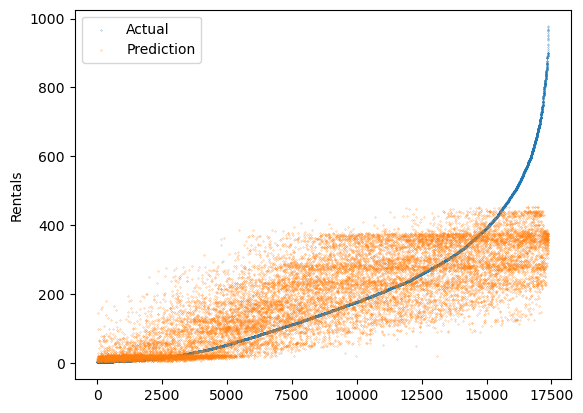

In [34]:
plt.scatter(range(rf_pred.shape[0]), rf_pred['cnt'], s=0.04, label='Actual')
plt.scatter(range(rf_pred.shape[0]), rf_pred['rf_predict'], s=0.04, label='Prediction')
plt.ylabel('Rentals')
plt.legend()
plt.show()

In [35]:
rf_rmses = mean_squared_error(rf_pred.loc[:, 'cnt'], rf_pred.loc[:, 'rf_predict'], squared=False)
rf_rmses

125.91380779751022